In [1]:
cd /home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src

/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src


In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath("./post_processing/local_calculations"))
sys.path.insert(0, os.path.abspath("./helper_functions/cloud"))
sys.path.insert(0, os.path.abspath("./file_manager"))
sys.path.insert(0, os.path.abspath("./hamiltonian"))
sys.path.insert(0, os.path.abspath("./correlation"))
sys.path.insert(0, os.path.abspath("./single_and_double_excitations_subspace"))

In [3]:
from qutip import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from hamiltonian.hamiltonian_builder import *


from helper_functions.operators import *
from helper_functions.cloud import *
from file_manager.visualization_preparation_tools import *
from file_manager.file_saver import *

from correlation.second_order_correlation  import *
from single_and_double_excitations_subspace.parameter_generator_for_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_optimized_ODE import *


from post_processing.local_calculations import *
from helper_functions.cloud import *
from helper_functions.operators import *
from helper_functions.other import * 

from scipy.stats import gmean

In [4]:
def relative_error(A,B, other = False):
    return np.abs(A-B)/(A+B)

In [5]:
def sandwich_E(r, Beta1D, Beta2D, n, optimized = False):
    #phase vector
    phase = np.exp(-1j*n.T @ r) #e^{-kvec x r}
    if optimized == False:
        s1 = 0
        s2 = 0
        for n in range(N):
            s1 += phase[0, n]*Beta1D[n]
            if Beta2D is not None: #not Single Excitation
                for m in range(N):
                    for j in range(N):
                        s2 += 4*phase[0,m]*phase.conj()[0,j]*(Beta2D[n][j].conj()*Beta2D[n][m] )

        s = np.abs(s1)**2 + s2
    else:
        
        #Matrix of difference of phases:
        phases_difference = np.exp(-1j*(np.reshape(np.subtract.outer(n.T @ r, n.T @ r), [N,N])))
        #First term
        s  = np.abs(np.einsum("ij,kj->",np.reshape(Beta1D, [1, N]), phase))**2 
        if Beta2D is not None: #Single Excitation
        #Second term
            s += 4*np.einsum('mj,nj,nm', phases_difference,Beta2D.conj().T, Beta2D)
        
    
    return s

In [6]:
def get_Beta1D_projected_state(r, Beta1D_steady_state, Beta2D_steady_state, n1, optimized = False):
    """ 
    Beta1D_steady_state, Beta2D_steady_state are both matrices not time evolution matrices
    """
    phase = np.exp(-1j*n1.T @ r)
    if optimized == False:
        numerator = np.zeros([N], dtype = "complex")
        for l in range(N):
            for m in range(N):
                numerator[l] += phase[0, m]*Beta2D_steady_state[l][m]
    else:
        numerator = np.einsum('ij,jk -> i', Beta2D_steady_state, phase.T)  
    
    denominator = np.sqrt(sandwich_E(r, Beta1D_steady_state, Beta2D_steady_state, n1) )

    return numerator/denominator



In [7]:
def get_g2(r, Beta1D_steady_state, Beta2D_steady_state, Beta1D_tau, Beta2D_tau, n1, n2, optimized = False):
    g2 = []
    if Beta2D_tau is None:
        for tau in range(len(Beta1D_tau)):
            g2.append(sandwich_E(r, Beta1D_tau[tau], None, n2, optimized)/ 
                  sandwich_E(r, Beta1D_steady_state, Beta2D_steady_state, n2, optimized))
        return g2 
    else:
        for tau in range(len(Beta1D_tau)):
            g2.append(sandwich_E(r, Beta1D_tau[tau], Beta2D_tau[tau], n2, optimized)/ 
                      sandwich_E(r, Beta1D_steady_state, Beta2D_steady_state, n2, optimized))
        return g2

### Testing g2

In [8]:
def get_g2_full_MonteCarlo(N, Omega, Delta, r, t_span_steady_state,R1, R2, single_excitation = False, Beta1D_steady_state = None, Beta2D_steady_state = None ):
    
    tf = 5 #shorter time
    taulist, dt = np.linspace(0,tf,200, retstep = True) 
    
    if Beta1D_steady_state is None and Beta2D_steady_state is None:
        Beta1D_t, Beta2D_t, t_span, r = SolveForBeta1DandBeta2D_optimized(N, kd = None , b0 = None, exc_radius = None, Delta = Delta, 
                                                                  Omega = Omega, wave_mixing = True, scalar = True,
                                                                  interaction = True, r = r, t_span =t_span_steady_state)  
    
        Beta1D_steady_state, Beta2D_steady_state = Beta1D_t[-1], Beta2D_t[-1]

    Beta1D_projected_state = get_Beta1D_projected_state(r, Beta1D_steady_state, Beta2D_steady_state, 
                                                        R1, optimized = True)
    
    
    if single_excitation == False:
        Beta1D_tau, Beta2D_tau, taulist, r = SolveForBeta1DandBeta2D_optimized(N, kd = None , b0 = None,
                                                                           exc_radius = None, Delta = Delta, 
                                                                           Omega = Omega, wave_mixing = True,
                                                                           scalar = True, interaction = True,
                                                                           r = r, t_span = taulist, 
                                                                           initial_Beta1D=Beta1D_projected_state) 
    else: 
        Beta1D_tau, taulist, r = SolveForBeta1D_optimized(N, kd = None , b0 = None,
                                                                           exc_radius = None, Delta = Delta, 
                                                                           Omega = Omega, wave_mixing = True,
                                                                           scalar = True, interaction = True,
                                                                           r = r, t_span = taulist, 
                                                                           initial_Beta1D=Beta1D_projected_state)
        Beta2D_tau = None
        
    
    
    g2_MonteCarlo = get_g2(r, Beta1D_steady_state, Beta2D_steady_state, 
                       Beta1D_tau, Beta2D_tau, R1, R2, optimized = True)
    
    return g2_MonteCarlo

def get_g2_full_exact(N, Omega, Delta, r, t_span_steady_state,R1, R2 ):
    tf = 5
    N_atoms = N
    taulist, dt = np.linspace(0,tf,200, retstep = True) 
    
    
    S_H, S_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = b0, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, r = r, beam = "plane_wave")
    rho_ss_S, total_time_ss = get_steadystate(S_H, 0, r,  b0, S_c_ops, N, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)
    G2_ls, normalization_ls, rho_ss, total_time_ss, total_time_correlation = g2_l(S_H, 0, r, R1, R2, taulist, S_c_ops, N, faseglobal = 1, rho_ss = rho_ss_S, rho_ss_parameter = "direct", tmax = None)
    g2_exact = G2_ls/normalization_ls
    
    return g2_exact

In [19]:
b0s = [0.1,1,2,3,5,7]
Omegas = [0.1,0.5,2, 6]



In [12]:
N_atoms = N = 200
b0 = 3
r = random_cloud(0, N, exc_radius = None, b0 = b0)

R1 = get_nhat_from_angle(25)
R2 = get_nhat_from_angle(205)

tf_steady_state = 100
Omega = 0.5
Delta = 20
t_span_steady_state, dt = np.linspace(0,tf_steady_state,50, retstep = True) 




In [22]:
%%time
Nuni = 200
r = random_cloud(0, Nuni, exc_radius = None, b0 = b0)

Beta1D_t, Beta2D_t, t_span, r = SolveForBeta1DandBeta2D_optimized(Nuni, kd = None , b0 = None, exc_radius = None, Delta = Delta, 
                                                                  Omega = Omega, wave_mixing = True, scalar = True,
                                                                  interaction = True, r = r, t_span =t_span_steady_state)  

CPU times: user 2min 31s, sys: 3.89 s, total: 2min 35s
Wall time: 1min 18s


In [23]:
%%time
g2_MonteCarlo_double_excitation = get_g2_full_MonteCarlo(Nuni, Omega, Delta, r, t_span_steady_state, R1, R2, single_excitation = False, Beta1D_steady_state= Beta1D_t[-1],Beta2D_steady_state= Beta2D_t[-1] )


CPU times: user 1min 50s, sys: 328 ms, total: 1min 51s
Wall time: 1min 45s


In [23]:

experiments = 20


b0s = [0.1,1,2,3,5,7]
Omegas = [0.1,0.5,2, 6]

for b0 in b0s:
    for Omega in Omegas:
        description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo"
        path_to_save_file = get_path_to_save_files(N, Omega, Delta,  description)                                                                
        filename ="{4}/N{3}_Omega{5}_Delta{6}_run".format(25,205,0,N,path_to_save_file, Omega, Delta) 
        for i in range(experiments):
            r = random_cloud(0, N, exc_radius = None, b0 = b0)
            g2_MonteCarlo_single_excitation = get_g2_full_MonteCarlo(N, Omega, Delta, r, t_span_steady_state, R1, R2, single_excitation = True )
            g2_MonteCarlo_double_excitation = get_g2_full_MonteCarlo(N, Omega, Delta, r, t_span_steady_state, R1, R2, single_excitation = False )

            g2_exact = get_g2_full_exact(N, Omega, Delta, r, t_span_steady_state,R1, R2 )
            run_number = get_new_run_number_dat(filename)
            name_of_file =  "{4}/N{3}_Omega{5}_Delta{6}_run{2}".format(25,205,run_number,N, path_to_save_file, Omega, Delta)
            np.save(name_of_file, [g2_MonteCarlo_double_excitation, g2_exact, g2_MonteCarlo_single_excitation])
            print(name_of_file)
    

oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run0
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run1
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run2
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run3
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run4
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega0.1_D

../results/N6_Omega2_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run4
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run5
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run6
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run7
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run8
oi
b0 system 0.1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_0.1_S_Int_On_avg_testing_benchmarking_with_single_excitati

../results/N6_Omega0.1_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run9
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run10
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run11
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run12
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run13
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_exci

oi
b0 system 1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run15
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run16
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run17
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run18
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_1_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run19
oi
b0 system 1
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_1_S_Int_On_avg_testing_benchm

oi
b0 system 2
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run1
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run2
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run3
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run4
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run5
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_2_S_Int_On_a

oi
b0 system 2
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run7
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run8
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run9
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run10
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_2_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run11
oi
b0 system 2
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_2_S_Int_On_avg_testing_benchmark

../results/N6_Omega0.5_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run12
oi
b0 system 3
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run13
oi
b0 system 3
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run14
oi
b0 system 3
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run15
oi
b0 system 3
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.5_Delta20_run16
oi
b0 system 3
kd system None
r is an array
../results/N6_Omega0.5_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_exc

oi
b0 system 3
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run18
oi
b0 system 3
kd system None
r is an array
../results/N6_Omega6_Delta20_b0_3_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega6_Delta20_run19
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run0
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run1
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run2
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_5_S_Int_On_avg_tes

oi
b0 system 5
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run3
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run4
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run5
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run6
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_5_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run7
oi
b0 system 5
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_5_S_Int_On_avg_testing_benchmarkin

oi
b0 system 7
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run9
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run10
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run11
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run12
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega0.1_Delta20_run13
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega0.1_Delta20_b0_7_S_Int_

../results/N6_Omega2_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run14
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run15
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run16
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run17
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo//N6_Omega2_Delta20_run18
oi
b0 system 7
kd system None
r is an array
../results/N6_Omega2_Delta20_b0_7_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montec

In [118]:
#N = 5
#Omega = 0.1

#N_atoms = N = 6
#b0 = 7
#Omega = 2
#Delta = 20
#description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_fixing_g2_with_montecarlo"




0.1 0.1
0.1 0.5
0.1 2
0.1 6
1 0.1
1 0.5
1 2
1 6
2 0.1
2 0.5
2 2
2 6
3 0.1
3 0.5
3 2
3 6
5 0.1
5 0.5
5 2
5 6
7 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


7 0.5
7 2
7 6


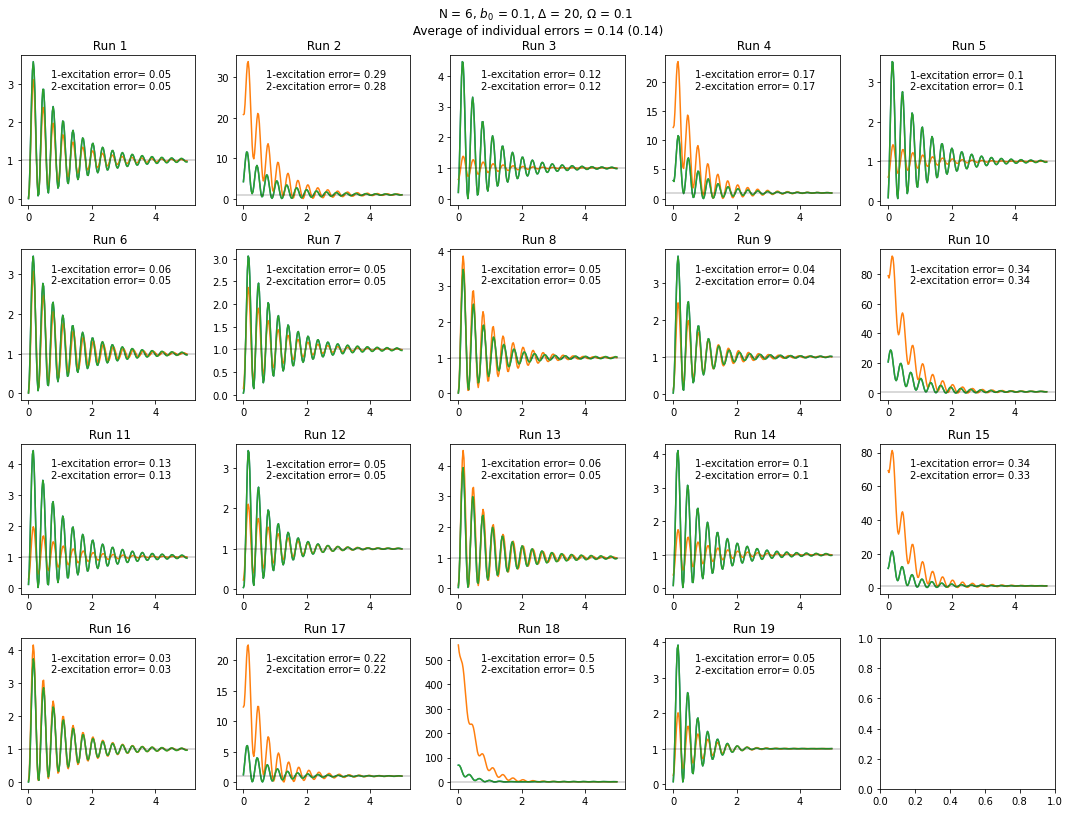

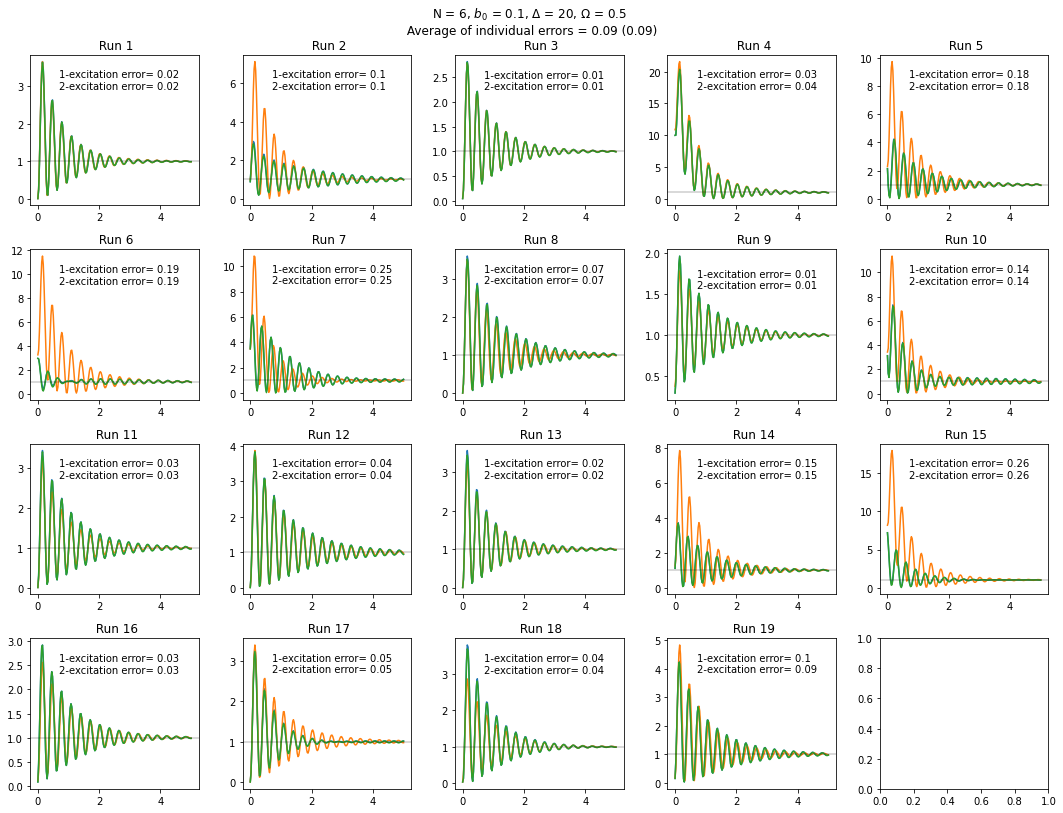

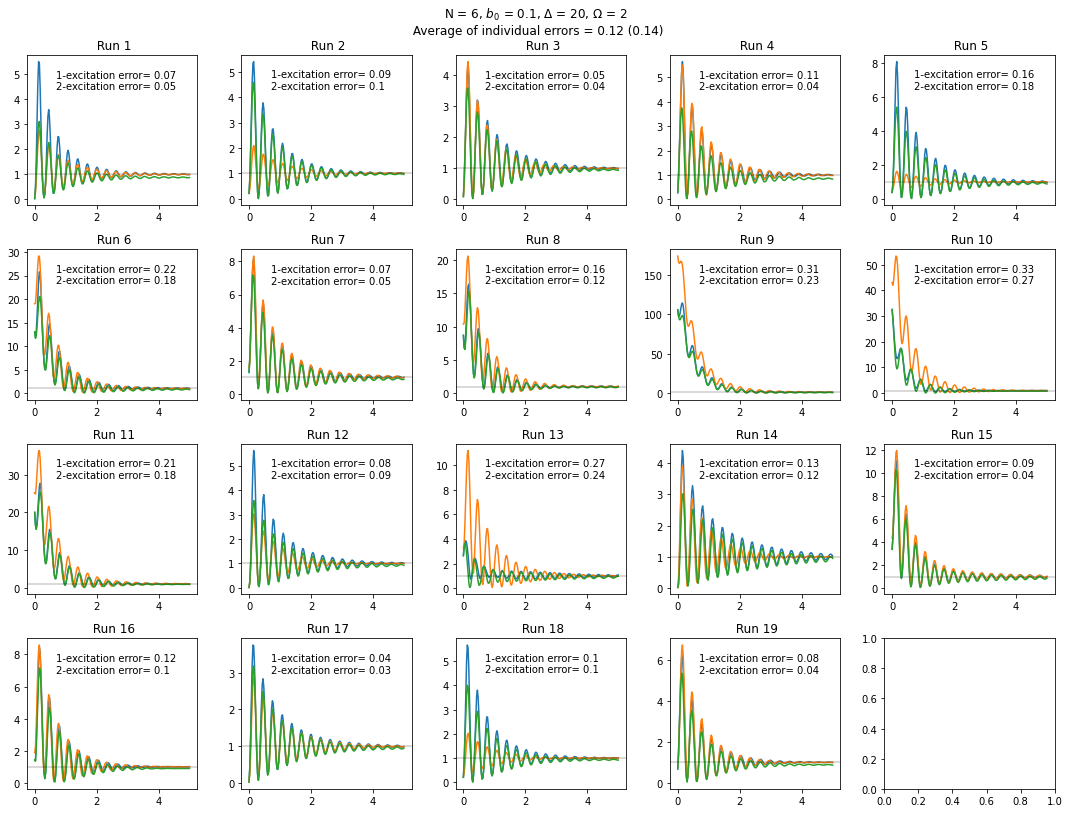

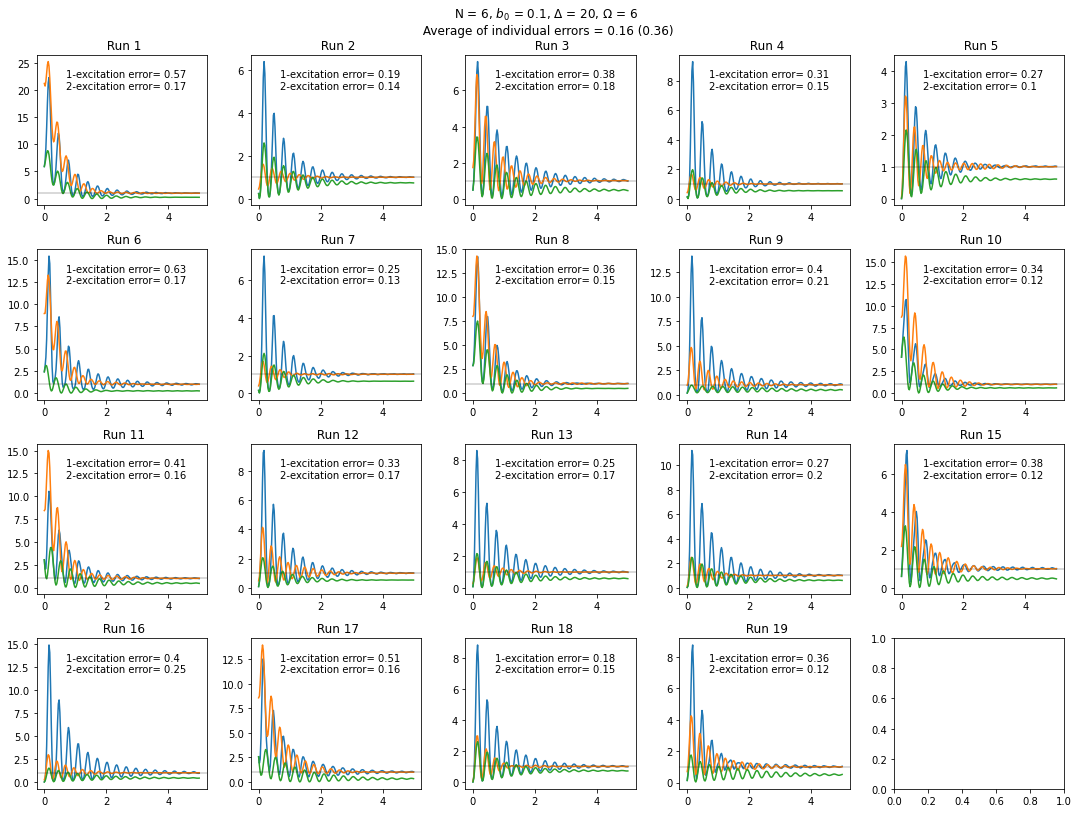

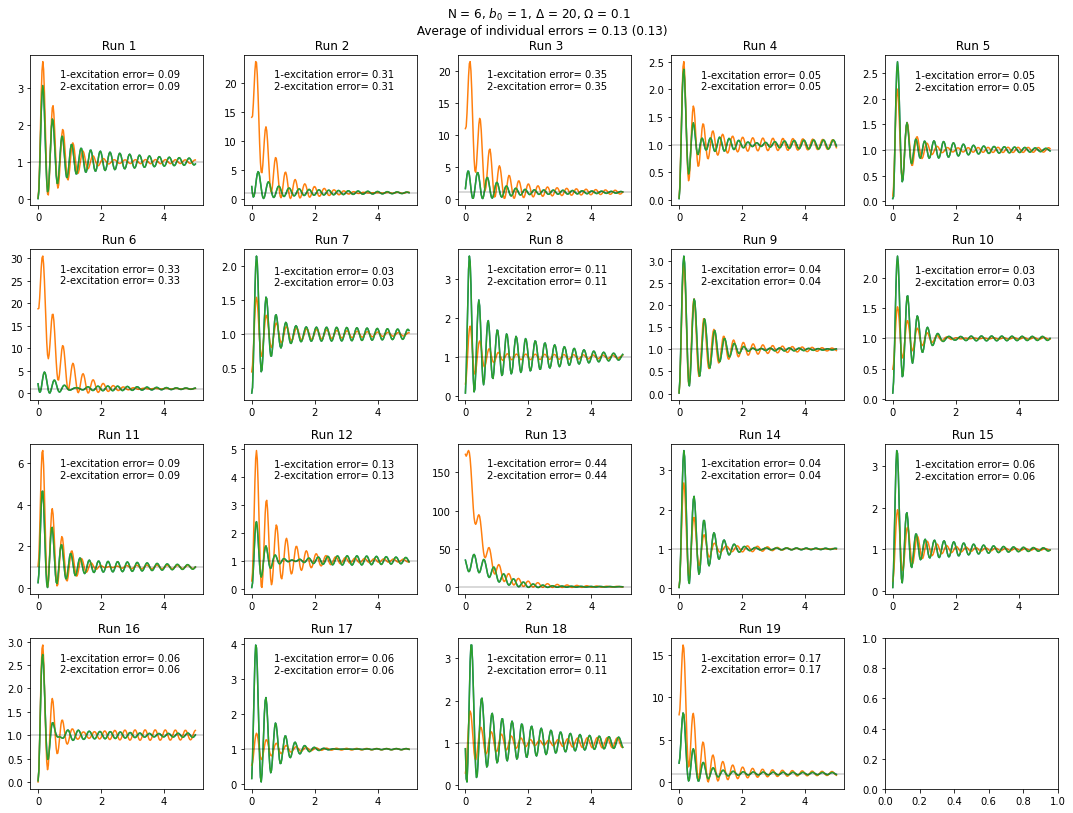

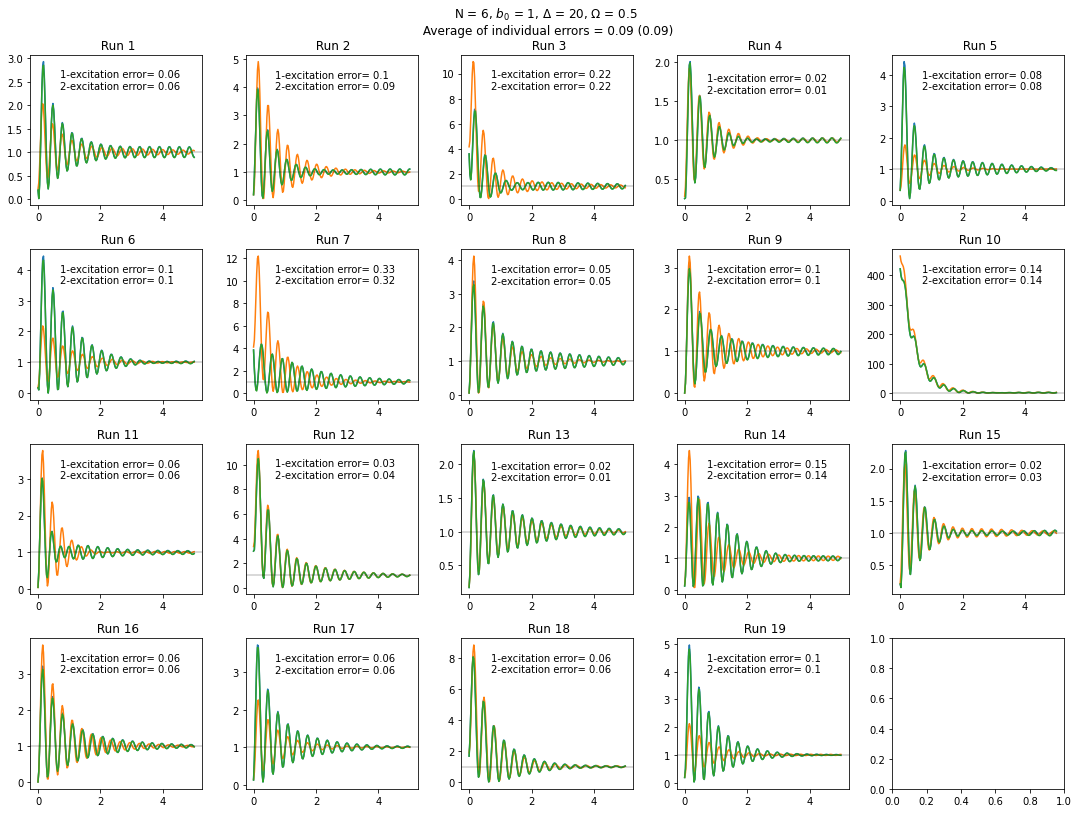

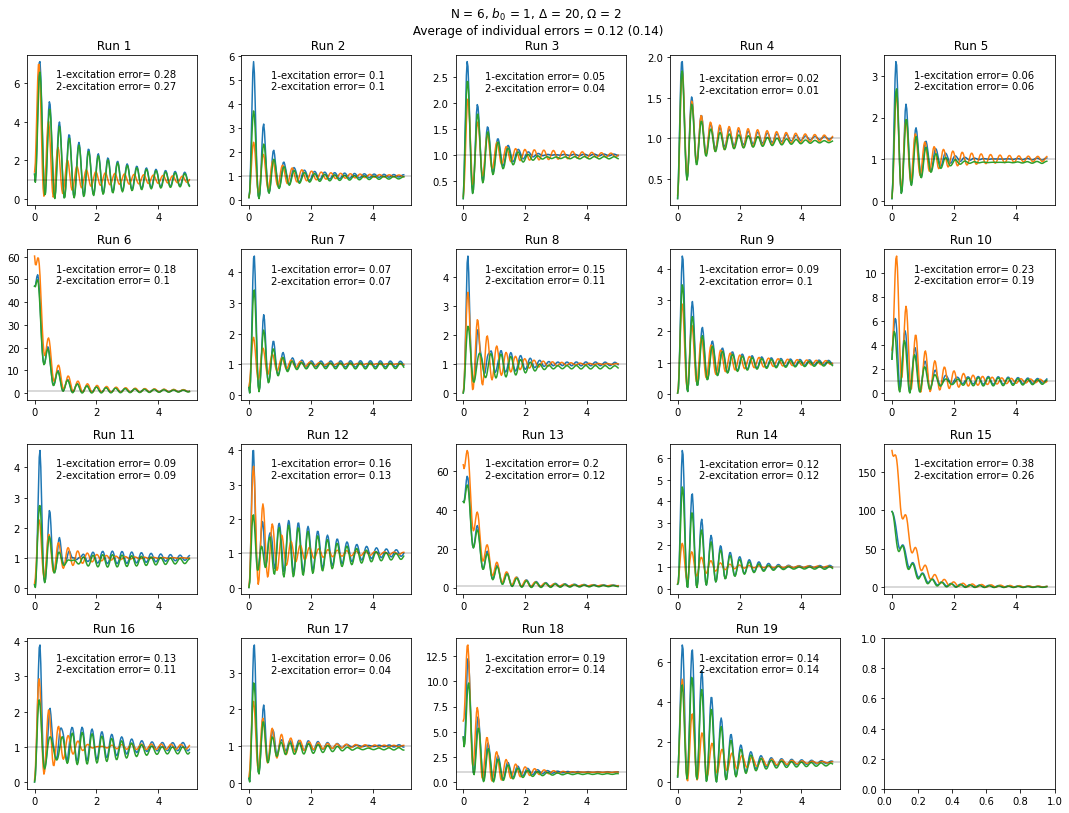

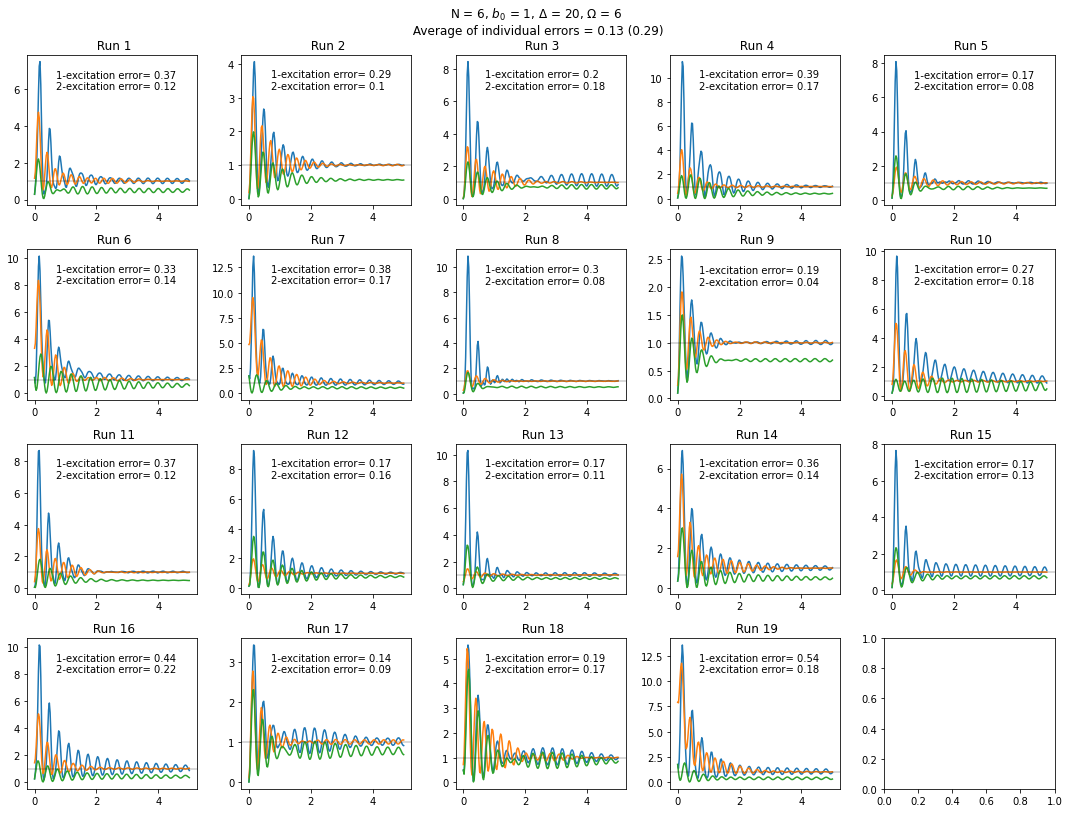

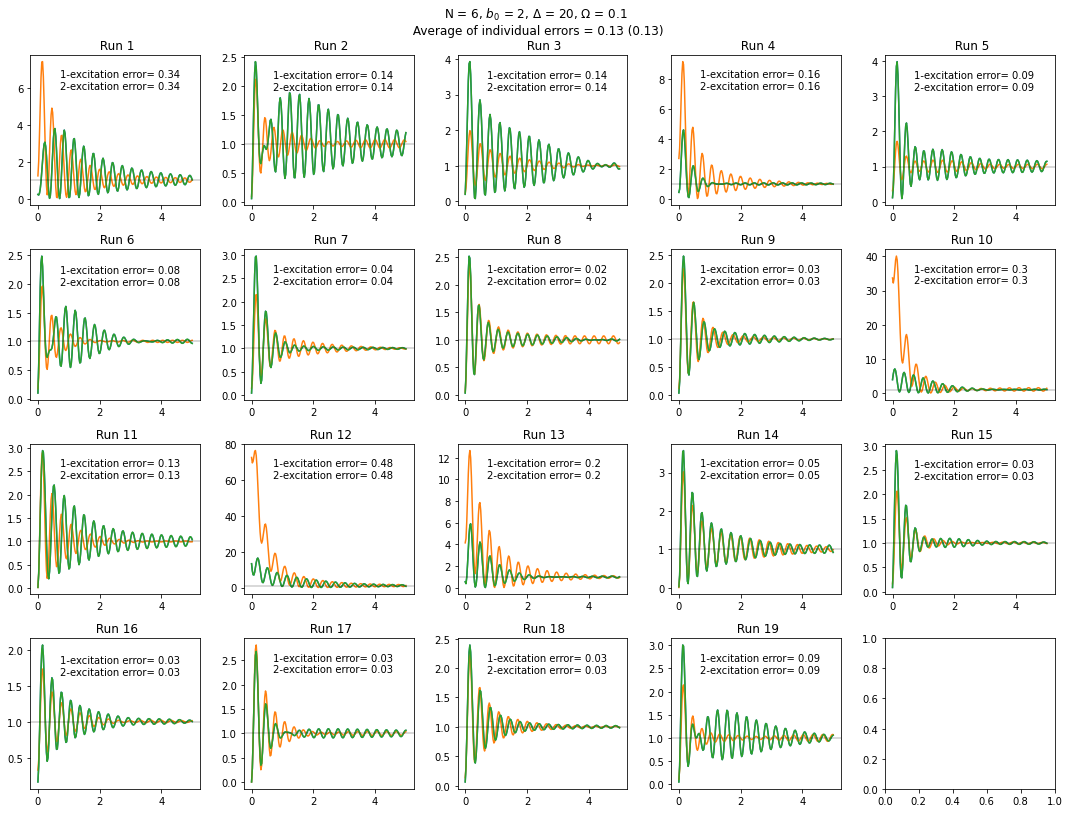

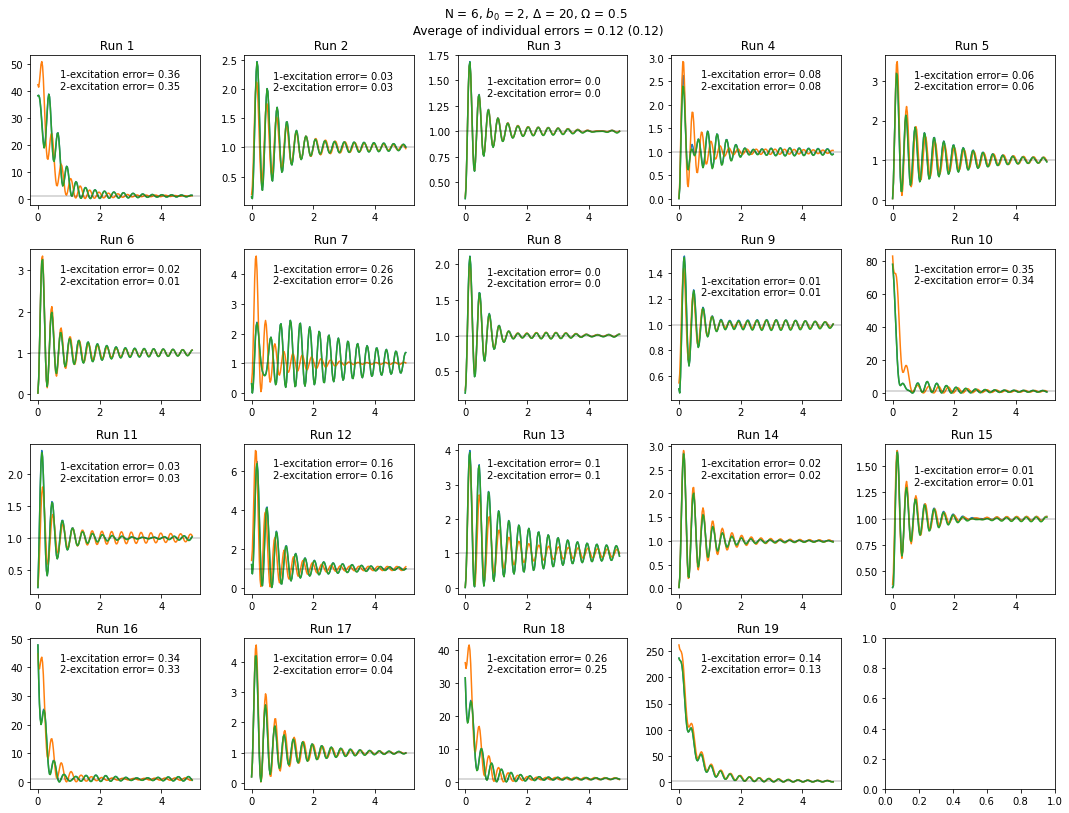

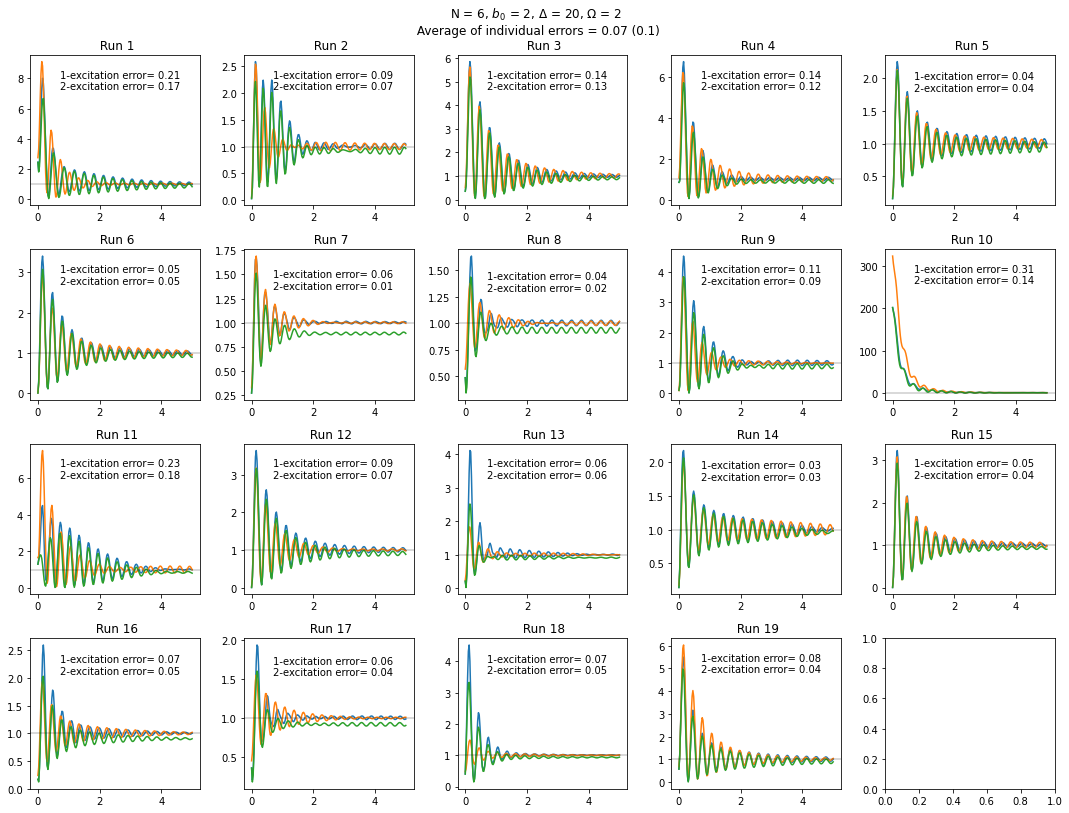

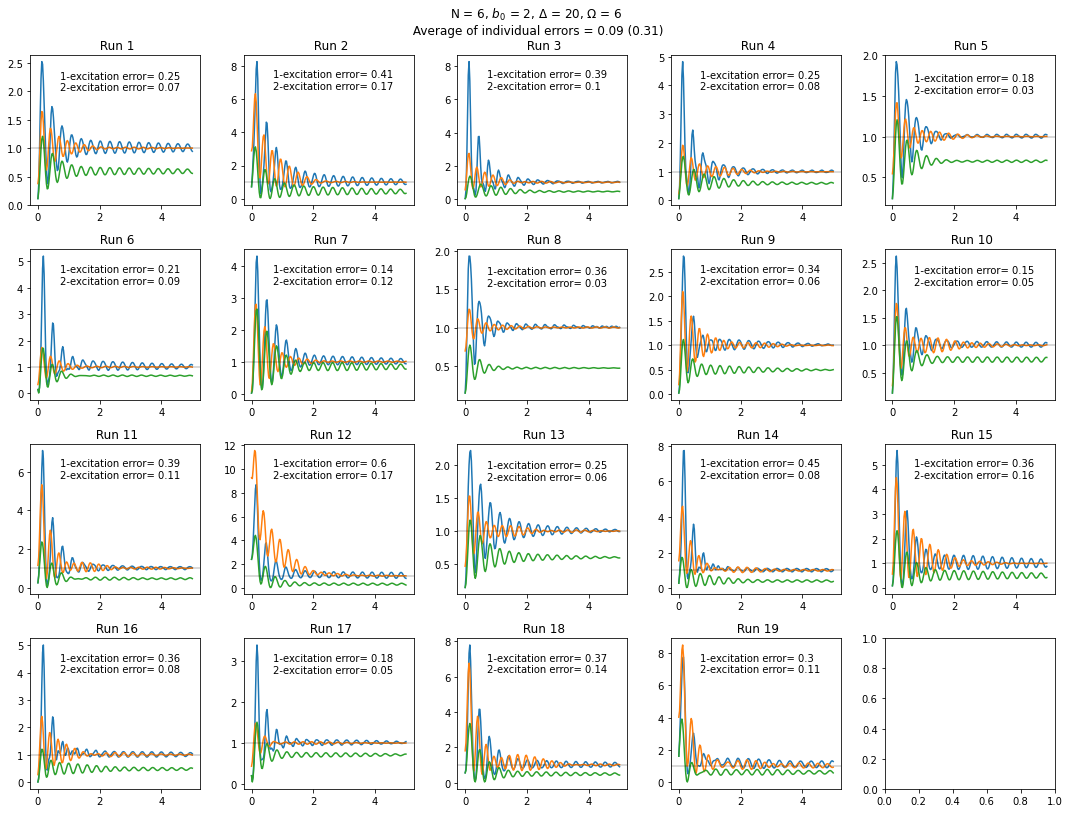

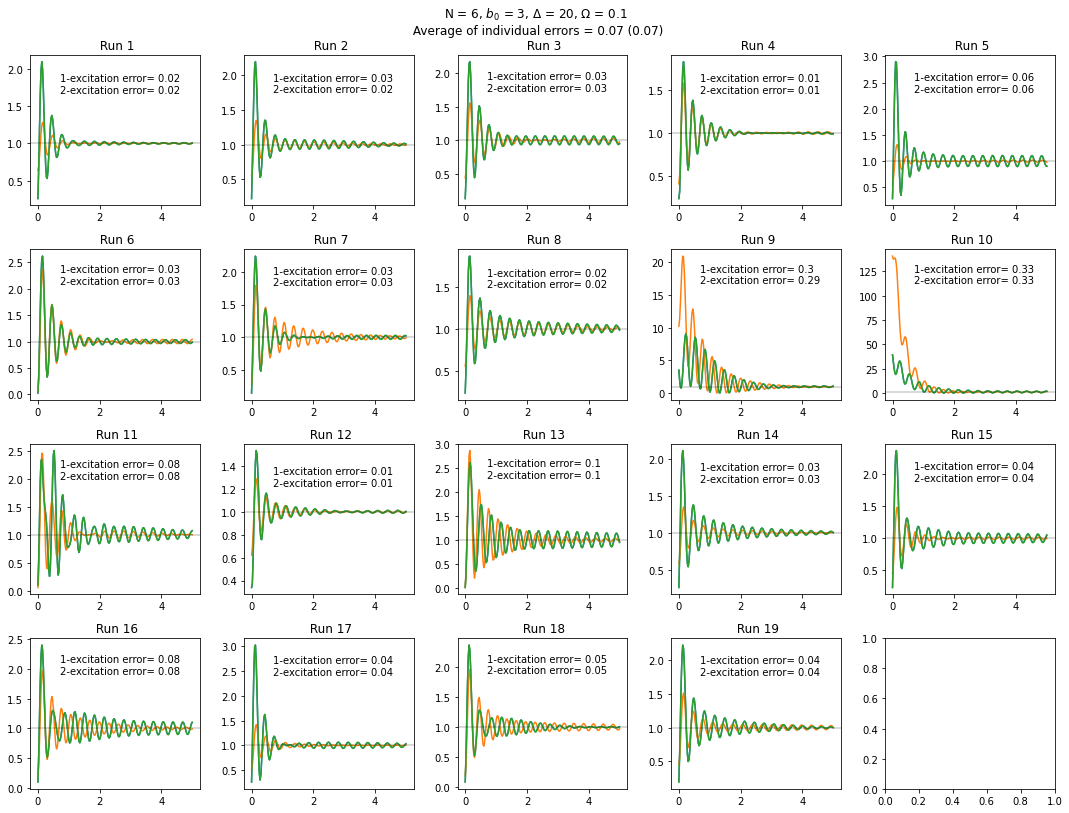

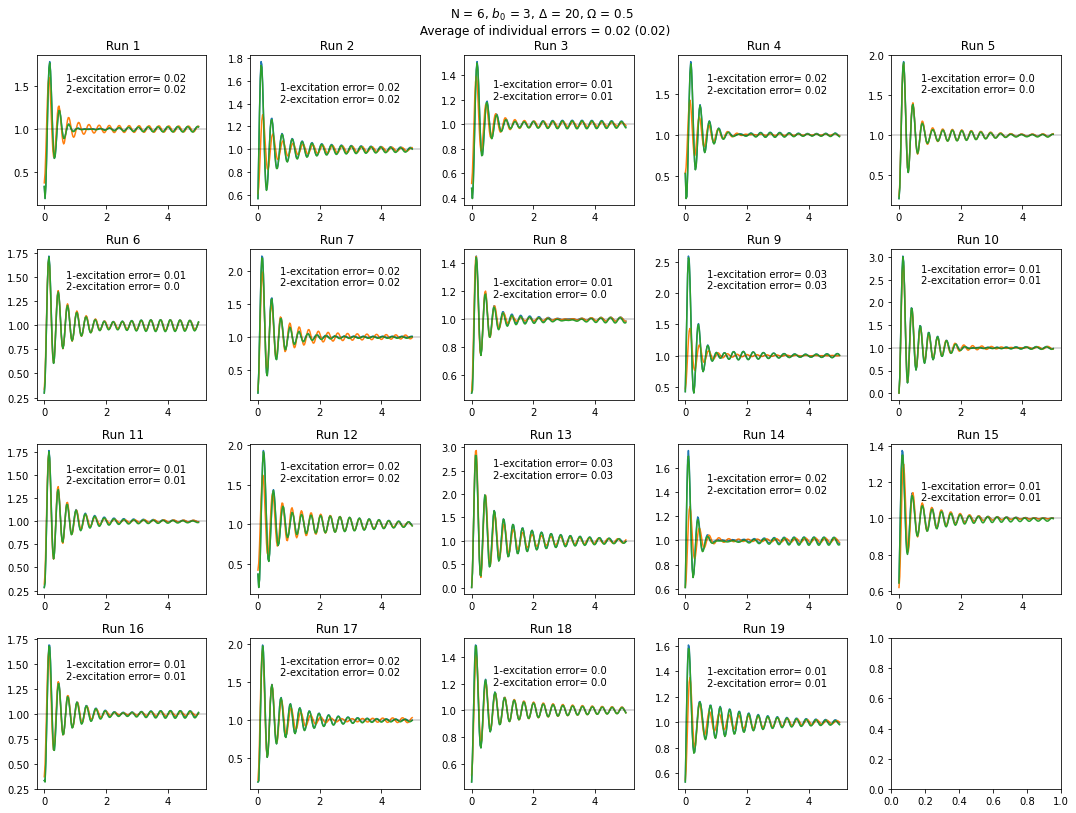

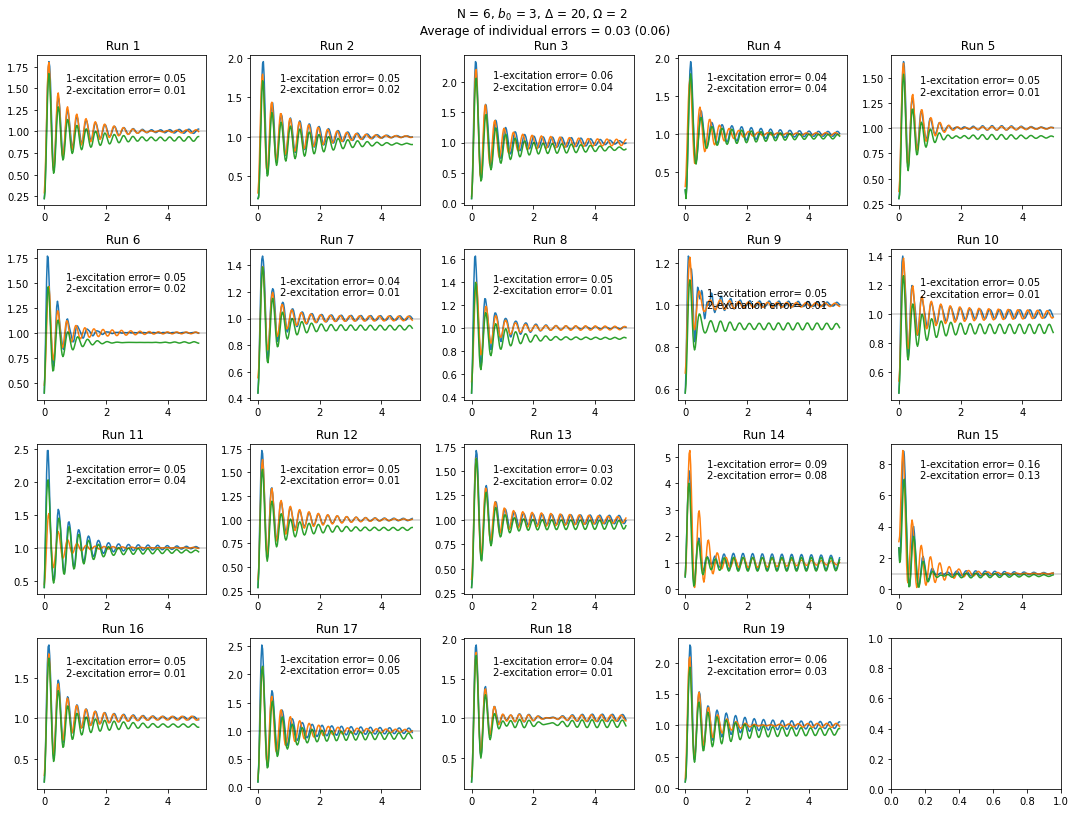

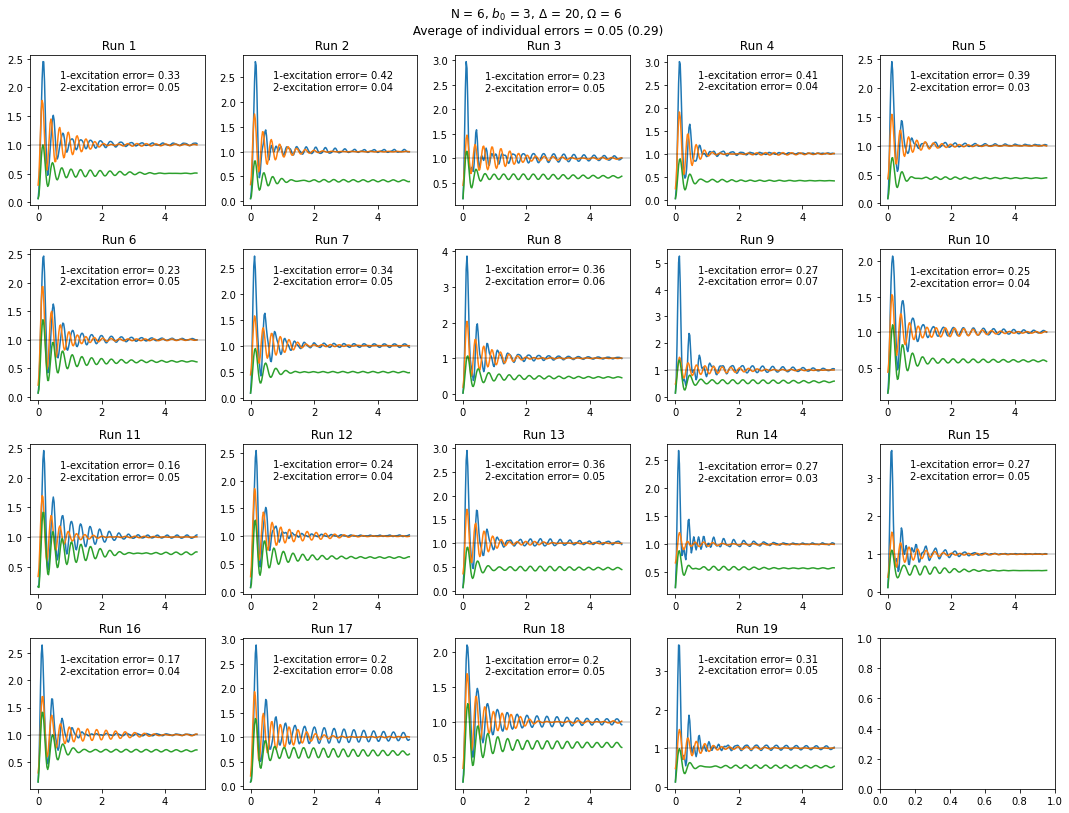

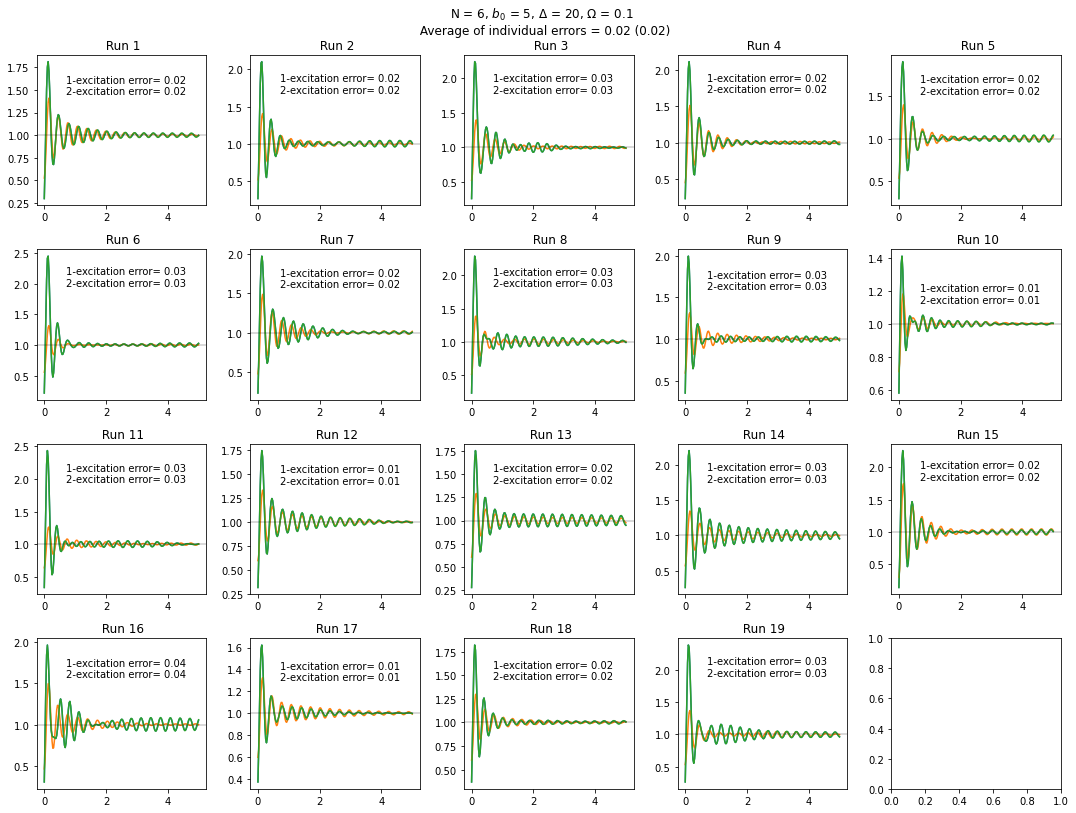

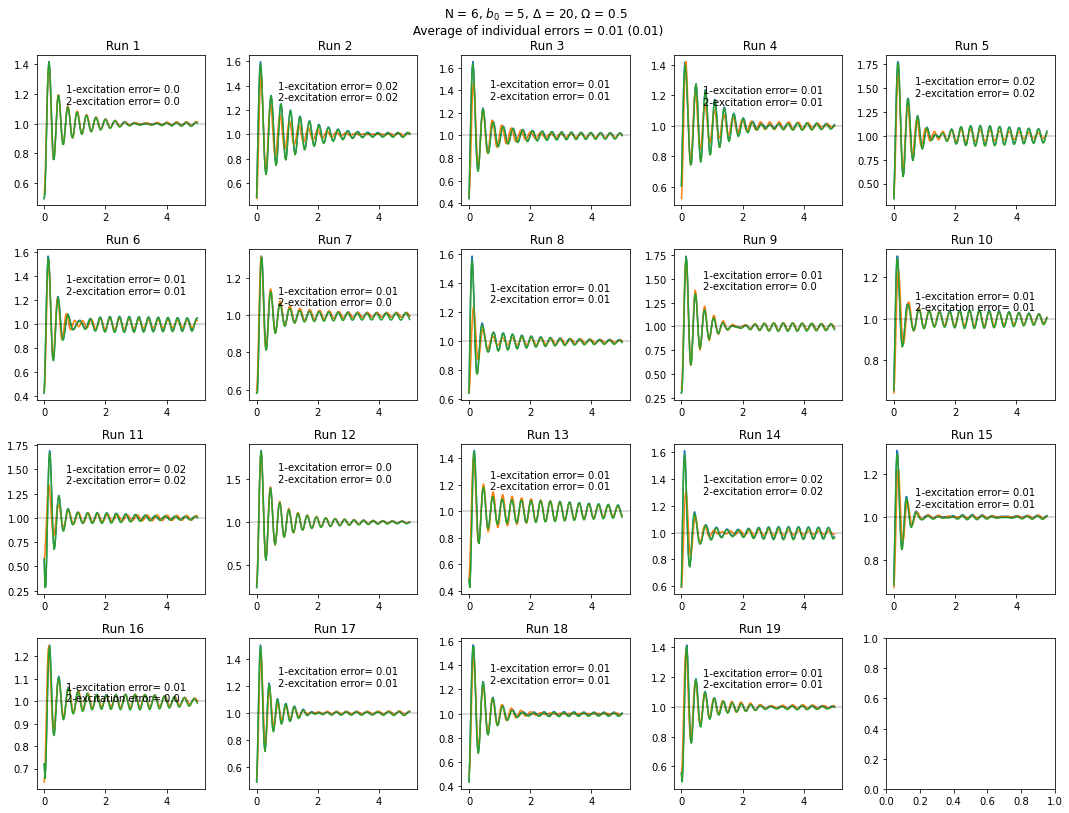

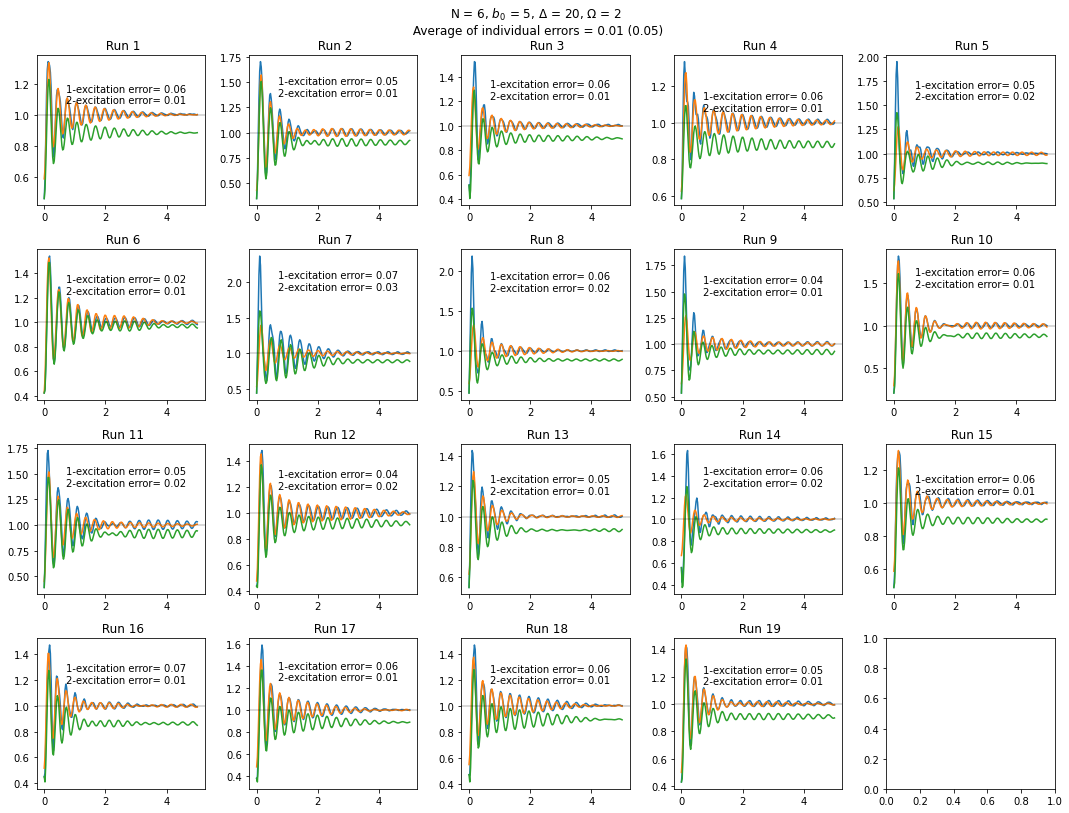

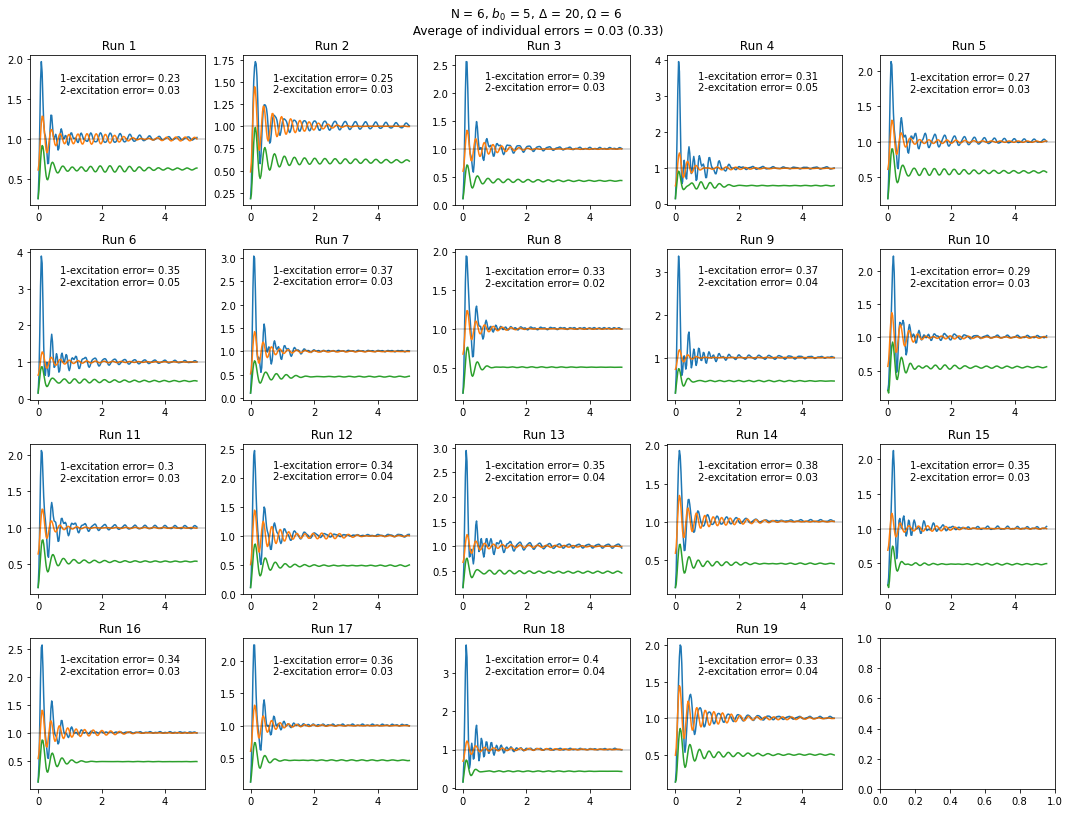

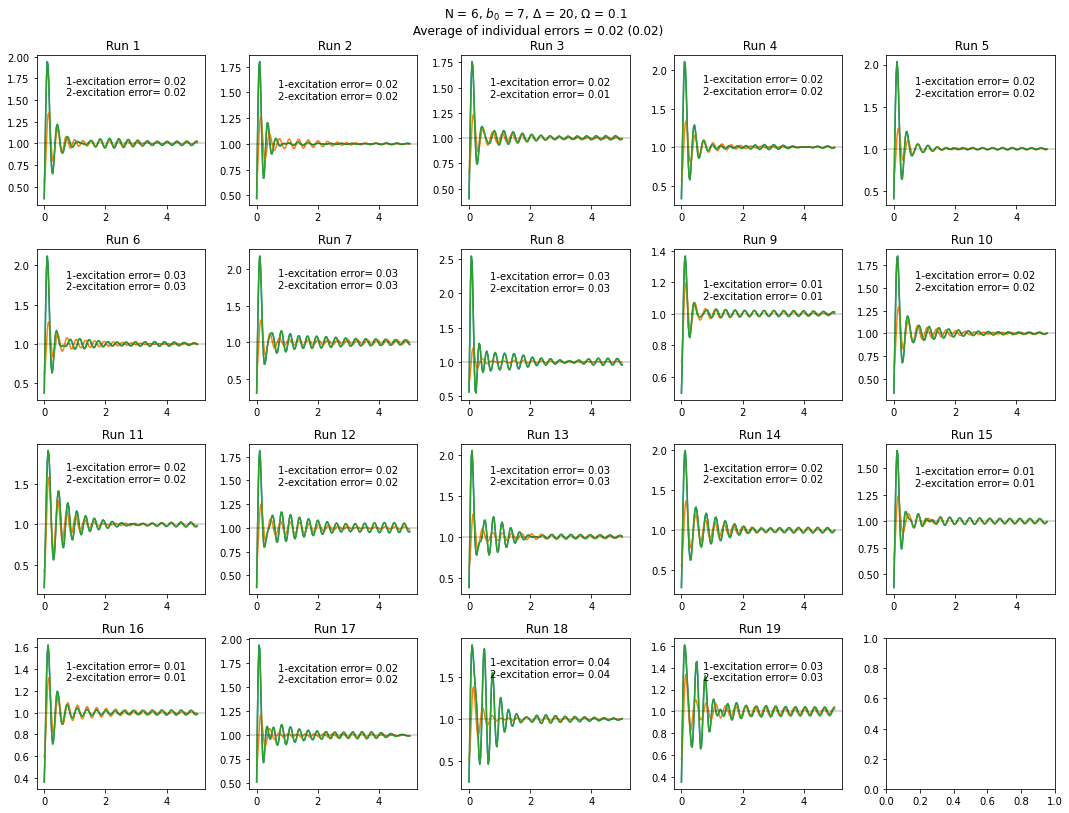

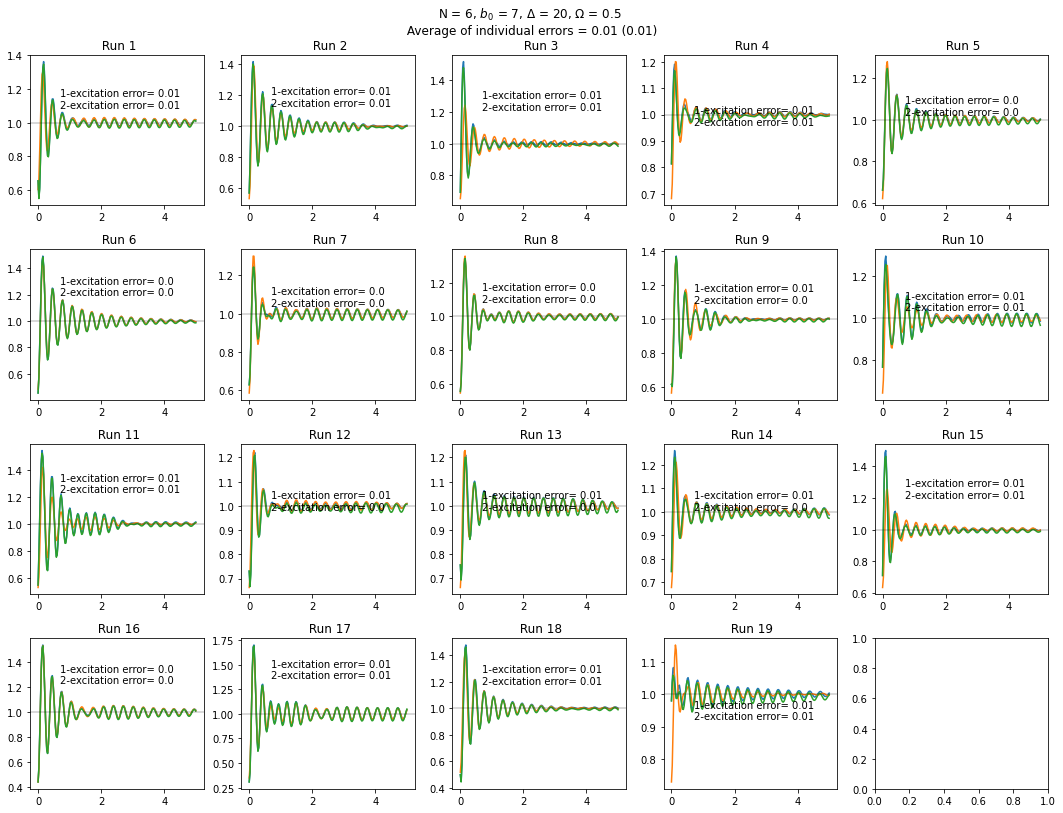

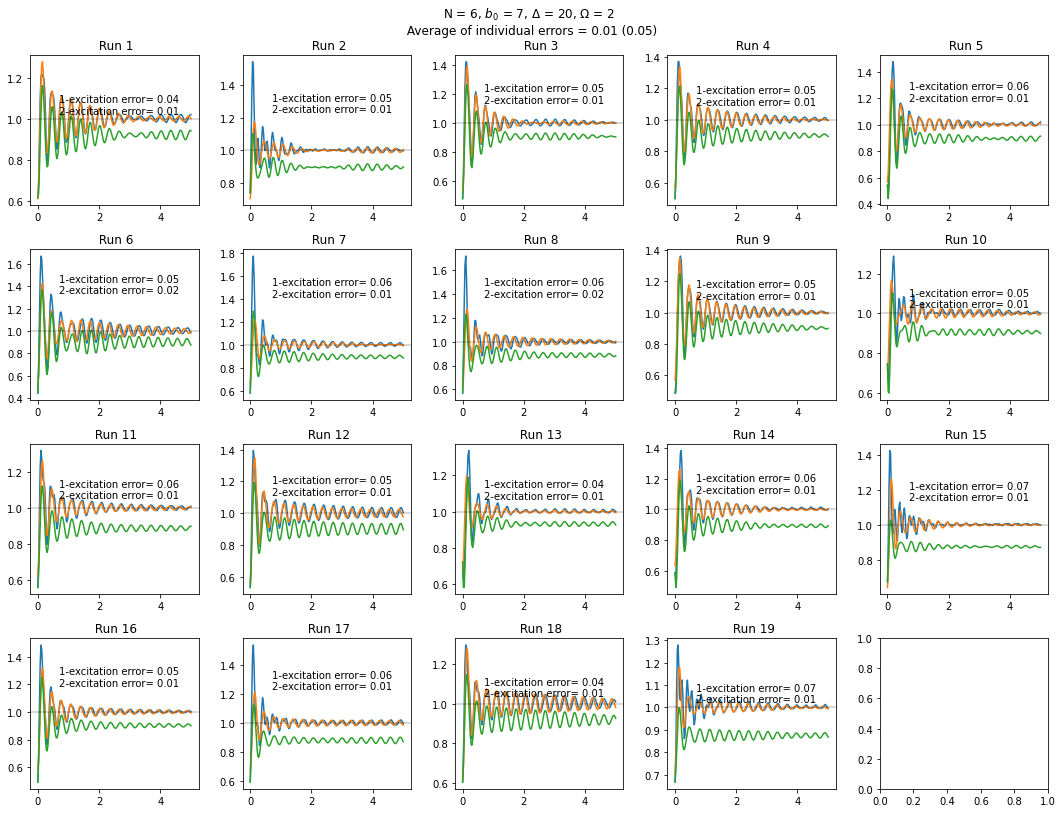

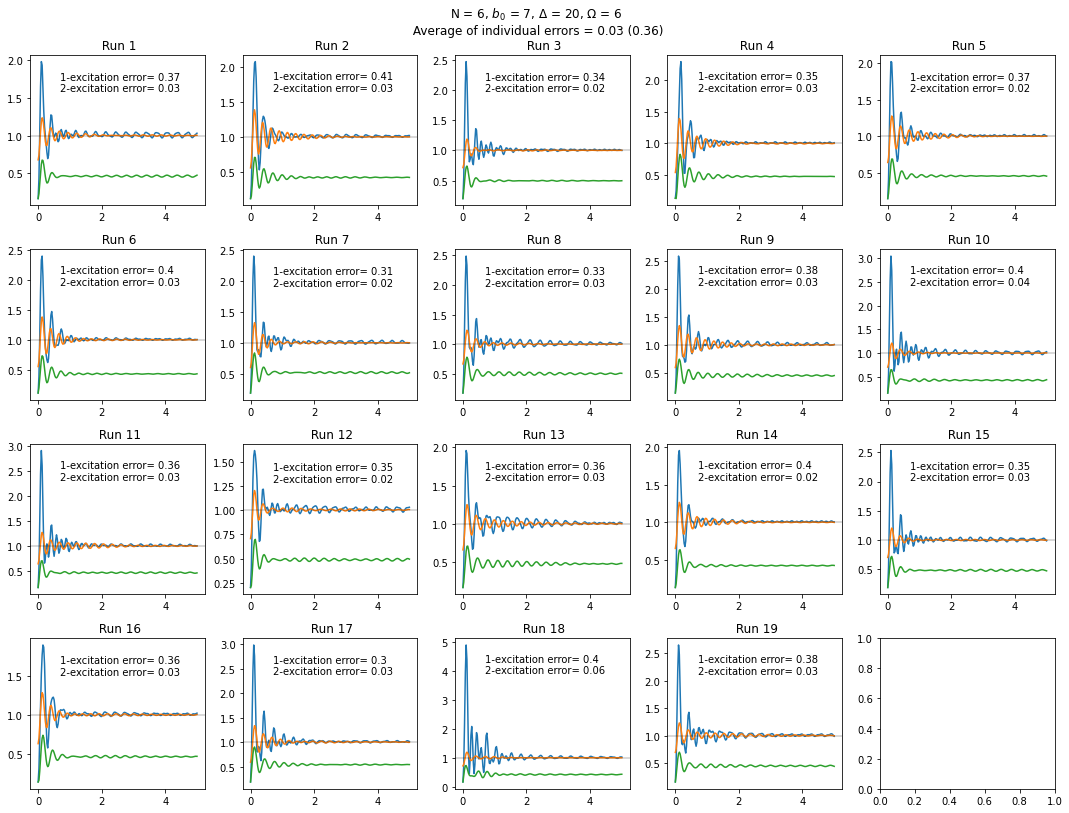

In [21]:
#b0s = [0.1,1,2,3,5,7]
#Omegas = [0.1,0.5,2, 6]

b0s = [0.1,1,2,3,5,7]

Omegas = [0.1]

N_atoms = N = 6
Delta = 20

for b0 in b0s:
    for Omega in Omegas:
        description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo"
        results_path = "../results/"
        DefaultInfo = f"N{N}_Omega{Omega}_Delta{Delta}_"
        defaultangle, angle = "25_", "205"
        rho_ss_parameter = "_direct"


        label_folder = results_path+DefaultInfo+description + "/" # "_"+ defaultangle +angle+ "_"   + rho_ss_parameter + "/"
        paths_array = get_array_of_runs_dat_files(label_folder) #all runs for a given phi
        runs_txt = get_array_of_numpy_runs(paths_array, npy = True)
        
        print (b0, Omega)
        
        
        fig = plt.figure(figsize = (15,14))
        
        tf = 5
        taulist, dt = np.linspace(0,tf,200, retstep = True)  


        rows = 5
        columns = 5
        initial = 0

        indexes_to_plot = list(range(initial, initial + rows*columns+1,1))


        relative_error_of_each_simulation = []
        relative_error_of_each_simulation_single_excitation = []

        for j in range(1,rows*columns+1):
            plt.subplot(rows, columns, j)#, sharey = plt.subplot(551))

            l = indexes_to_plot[j]
            try:
                avg_relative_error = np.average(relative_error(np.real(runs_txt[l])[0], np.real(runs_txt[l][1])))
                avg_relative_error_single_excitation = np.average(relative_error(np.real(runs_txt[l])[2], np.real(runs_txt[l][1])))

                relative_error_of_each_simulation.append(avg_relative_error)
                relative_error_of_each_simulation_single_excitation.append(avg_relative_error_single_excitation)

            except:
                break
            #plt.title(f" Run {l}:"+ r"$<1-g^{(2)}_{MC}/g^{(2)}_{qutip}>$"+ f"= {np.round(avg_relative_error, 2)}. ", loc = "left") 


            plt.title(f" Run {l}")

            plt.plot( taulist, np.real(runs_txt[l][0]))
            plt.plot( taulist, np.real(runs_txt[l][1]))
            plt.plot( taulist, np.real(runs_txt[l][2]))

            plt.axhline(1, color = "black", alpha = 0.2)


            plt.text(0.7, np.max(np.real(runs_txt[l][:]))*0.80, r"1-excitation error"+ f"= {np.round(avg_relative_error_single_excitation, 2)} \n2-excitation error"+ f"= {np.round(avg_relative_error, 2)}" )

        plt.suptitle(f"N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega} \n Average of individual errors = {np.round(np.average(relative_error_of_each_simulation), 2)} ({np.round(np.average(relative_error_of_each_simulation_single_excitation), 2)})")
        plt.tight_layout()

        plt.savefig(f"./benchmarking/N{N}_Omega{Omega}_Delta_{Delta}_b0_{b0}_single_excitation_g2_qutip_vs_MC_avg_error_{rows}x{columns}.png", dpi = 300)

0.1 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.1 0.5


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.1 2


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.1 6


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1 0.5


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1 2


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1 6


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2 0.5


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2 2


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2 6


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


3 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


3 0.5


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


3 2


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


3 6


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


5 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


5 0.5


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


5 2


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


5 6


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


7 0.1


/home/roberto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


7 0.5


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


7 2


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


7 6


/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


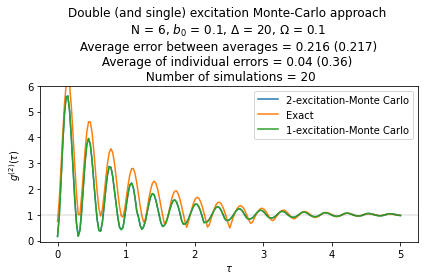

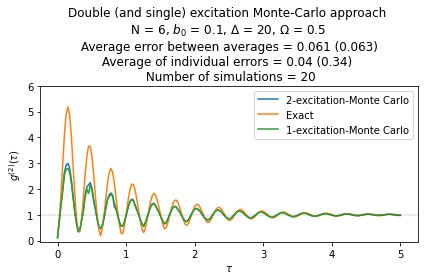

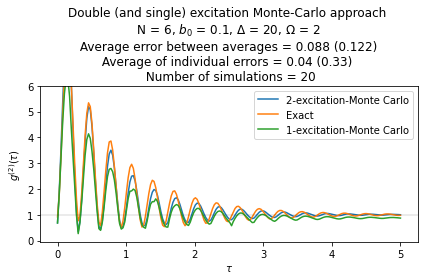

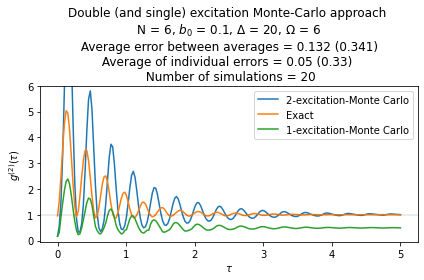

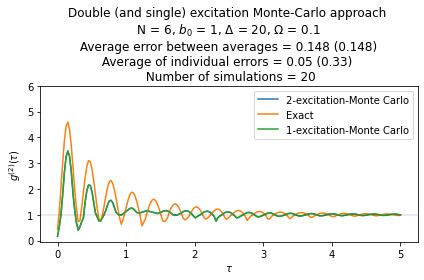

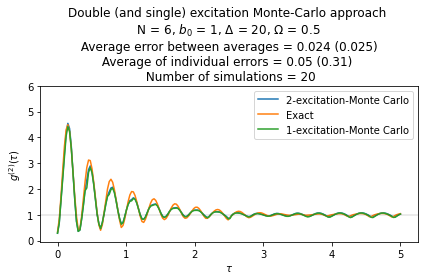

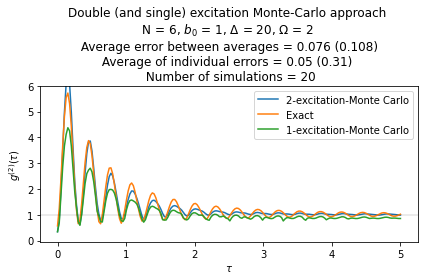

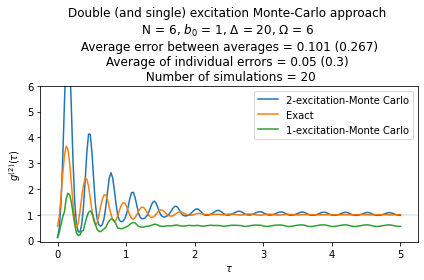

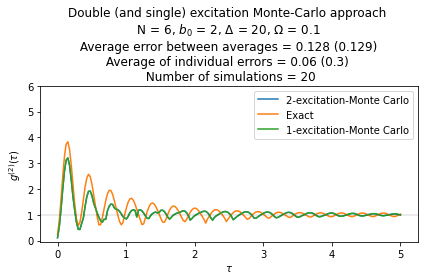

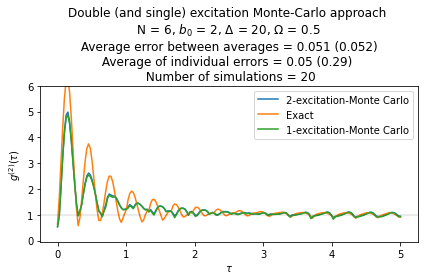

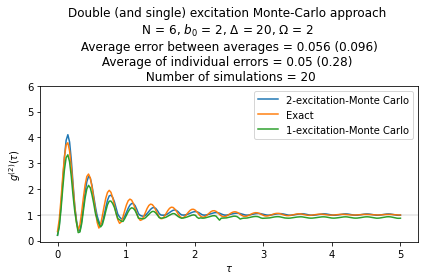

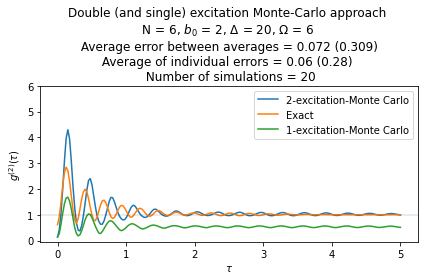

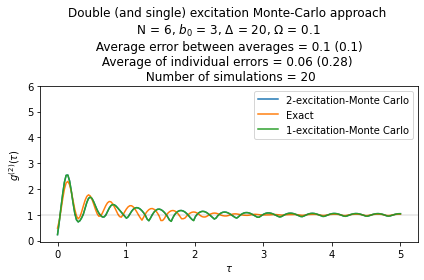

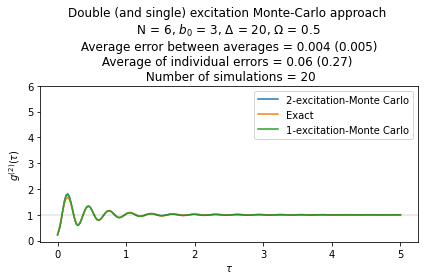

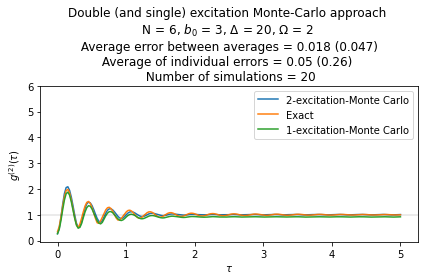

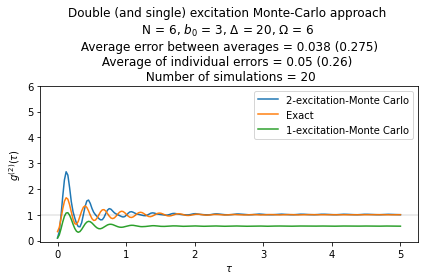

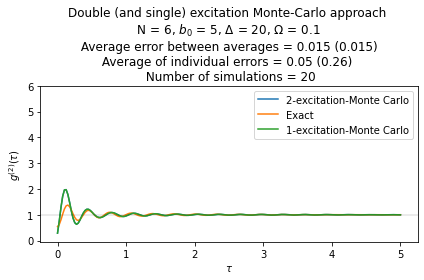

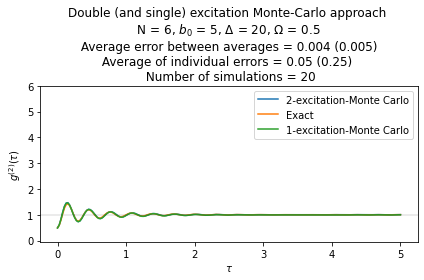

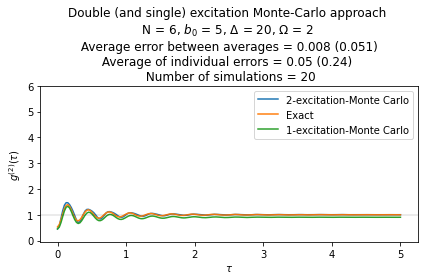

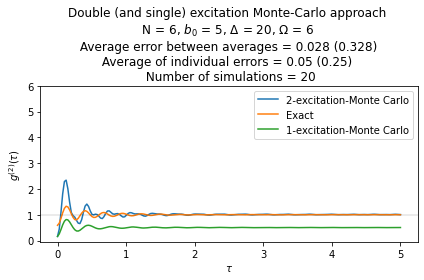

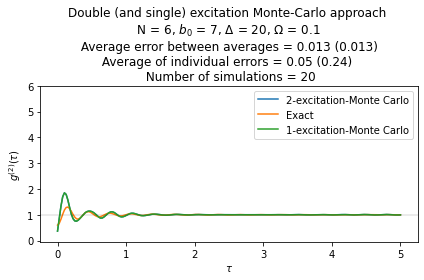

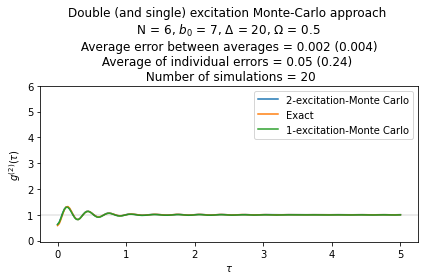

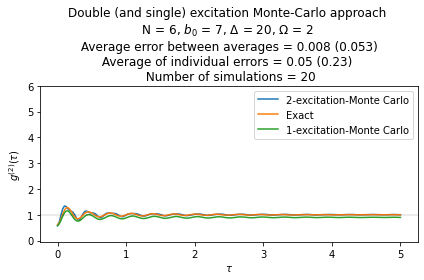

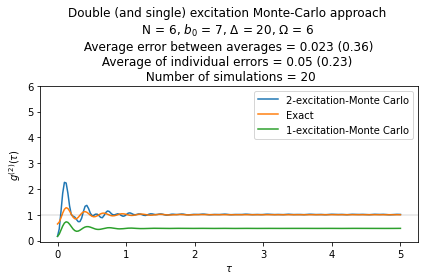

In [26]:
b0s = [0.1,1,2,3,5,7]
Omegas = [0.1,0.5,2, 6]

#b0s = [0.1]
#Omegas = [6]
N_atoms = N = 6
Delta = 20

for b0 in b0s:
    for Omega in Omegas:
        description = f"b0_{b0}_S_Int_On_avg_testing_benchmarking_with_single_excitation_g2_with_montecarlo"
        results_path = "../results/"
        DefaultInfo = f"N{N}_Omega{Omega}_Delta{Delta}_"
        defaultangle, angle = "25_", "205"
        rho_ss_parameter = "_direct"


        label_folder = results_path+DefaultInfo+description + "/" # "_"+ defaultangle +angle+ "_"   + rho_ss_parameter + "/"
        paths_array = get_array_of_runs_dat_files(label_folder) #all runs for a given phi
        runs_txt = get_array_of_numpy_runs(paths_array, npy = True)
        
        print (b0, Omega)
        
        
        fig = plt.figure()
        
        plt.ylim(-0.05, 6)
        
        plt.plot( taulist, gmean(runs_txt, axis = 0)[0], label = "2-excitation-Monte Carlo")
        plt.plot( taulist, gmean(runs_txt, axis = 0)[1], label = "Exact")
        plt.plot( taulist, gmean(runs_txt, axis = 0)[2], label = "1-excitation-Monte Carlo")
        plt.axhline(1, color = "black", alpha = 0.1)

        avg_relative_error = np.average(relative_error(np.real(np.average(runs_txt, axis = 0))[0], np.real(np.average(runs_txt, axis = 0)[1]), other= False))
        avg_relative_error_single_excitation =  np.average(relative_error(np.real(np.average(runs_txt, axis = 0))[2], np.real(np.average(runs_txt, axis = 0)[1]), other= False))           

        relative_error_of_each_simulation.append(avg_relative_error)
        relative_error_of_each_simulation_single_excitation.append(avg_relative_error_single_excitation)
        
        plt.title(f"Double (and single) excitation Monte-Carlo approach \n N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega}  \n Average error between averages = {np.round(avg_relative_error, 3)} ({np.round(avg_relative_error_single_excitation, 3)}) \n Average of individual errors = {np.round(np.average(relative_error_of_each_simulation), 2)} ({np.round(np.average(relative_error_of_each_simulation_single_excitation), 2)})  \n Number of simulations = {len(runs_txt)}")
        plt.xlabel(r"$\tau$ ")
        plt.ylabel(r"$ g^{(2)}(\tau)  $")


        plt.legend()
        plt.tight_layout()
        plt.savefig(f"./benchmarking/N{N}_Omega{Omega}_Delta_{Delta}_b0_{b0}_single_excitation_lim_g2_qutip_vs_MC_avg_error_averages.png", dpi = 300)

In [22]:
runs_txt

[array([[0.19883895-3.90614478e-19j, 0.43795789+3.55971451e-18j,
         0.97343688-8.52947873e-18j, 1.5062132 -2.48783450e-17j,
         1.79451163+6.40050073e-18j, 1.7870159 +1.36527716e-17j,
         1.6052932 -2.02134903e-17j, 1.40240494-2.65159831e-18j,
         1.24465963-1.18539143e-17j, 1.10058137-2.29441621e-17j,
         0.92456806+6.97215598e-18j, 0.74181103-1.66561165e-17j,
         0.64267903+6.28519828e-18j, 0.70331284-4.51100100e-19j,
         0.90607063-2.60710273e-18j, 1.13983268+3.80842944e-17j,
         1.28051877-2.44349735e-17j, 1.27659521+3.43728531e-18j,
         1.17682424-3.48549512e-17j, 1.07189506+3.24034630e-19j,
         1.01972463-1.06882802e-17j, 1.00949189+1.83853983e-17j,
         0.99477662-4.22887272e-18j, 0.95080134-6.62392857e-18j,
         0.9015487 -1.87276071e-17j, 0.89534375+1.18890614e-17j,
         0.95351845+5.15759393e-18j, 1.04593099-1.64113302e-18j,
         1.1131139 +3.98151440e-19j, 1.1151524 +4.42649377e-18j,
         1.06227393+4.426